In [5]:
from typing import Callable, Iterator, Sequence, Tuple
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
from jax import random, jit, grad, value_and_grad
from flax.training import train_state

import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

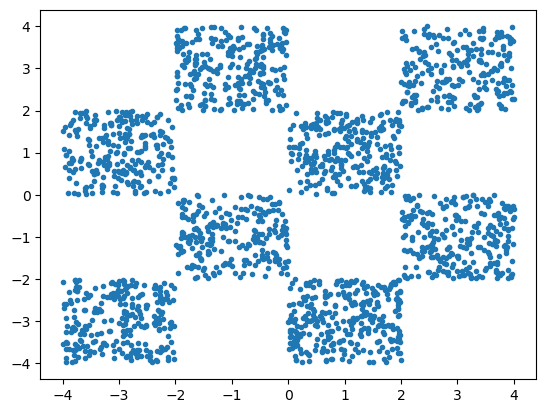

In [3]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x

X_train = generate_checkerboard(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

In [4]:
Activation = Callable[[jax.numpy.ndarray], jax.numpy.ndarray]

class DiffusionMLP(nn.Module):
    features: Sequence[int]
    activation: Activation = nn.relu

    @nn.compact
    def __call__(self, x: jax.numpy.ndarray, train: bool = False) -> jax.numpy.ndarray:
        # The train parameter is accepted but not used since there's no specific behavior like dropout.
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        
        # Assuming the output layer predicts eps parameters (noise)
        eps = nn.Dense(x.shape[-1])(x)
        
        return eps
    
model = DiffusionMLP(features=[64, 64, 64])
print(model.tabulate(jax.random.PRNGKey(0), jnp.zeros((1, 2))))


                              DiffusionMLP Summary                              
┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module       ┃ inputs        ┃ outputs       ┃ params              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│         │ DiffusionMLP │ float32[1,2]  │ float32[1,64] │                     │
├─────────┼──────────────┼───────────────┼───────────────┼─────────────────────┤
│ Dense_0 │ Dense        │ float32[1,2]  │ float32[1,64] │ bias: float32[64]   │
│         │              │               │               │ kernel:             │
│         │              │               │               │ float32[2,64]       │
│         │              │               │               │                     │
│         │              │               │               │ 192 (768 B)         │
├─────────┼──────────────┼───────────────┼───────────────┼─────────────────────┤
│ Dense_1 │ Dense        │ 

In [6]:
class Scheduler:
    def __init__(self, num_timesteps):
        self.num_timesteps = num_timesteps

    def sample_timesteps(self, key, batch_size):
        return random.randint(key, (batch_size,), 0, self.num_timesteps)

# Define the training state
class TrainState(train_state.TrainState):
    scheduler: Scheduler


In [7]:
def create_train_state(rng, model, learning_rate):
    params = model.init(rng, jnp.ones((1, 1, 64, 64)), rng)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx, scheduler=Scheduler(num_train_timesteps=1000))

@jit
def train_step(state, batch, rng):
    def loss_fn(params):
        noise = random.normal(rng, batch['image'].shape)
        timesteps = state.scheduler.sample_timesteps(rng, batch['image'].shape[0])
        preds = state.apply_fn({'params': params}, batch['image'], rng)
        loss = jnp.mean((preds - noise) ** 2)
        return loss

    loss, grads = value_and_grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads), loss

# Example usage
rng = random.PRNGKey(0)
state = create_train_state(rng, model, 2.5e-5)


TypeError: Scheduler.__init__() got an unexpected keyword argument 'num_train_timesteps'